# Plot the Data
This notebook explores the data and transforms it for final use

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import imageio
from pathlib import Path
import seaborn as sns


notebook_dir = Path().resolve()
parent_dir = notebook_dir.parent

df_worker = pd.read_csv(parent_dir / 'drought_data_output/spei3_hf_raw.csv')
df_worker['date'] = pd.to_datetime(df_worker['date'])

## Plot the SPEI

These below are the high frequency SPEI observation for all districts

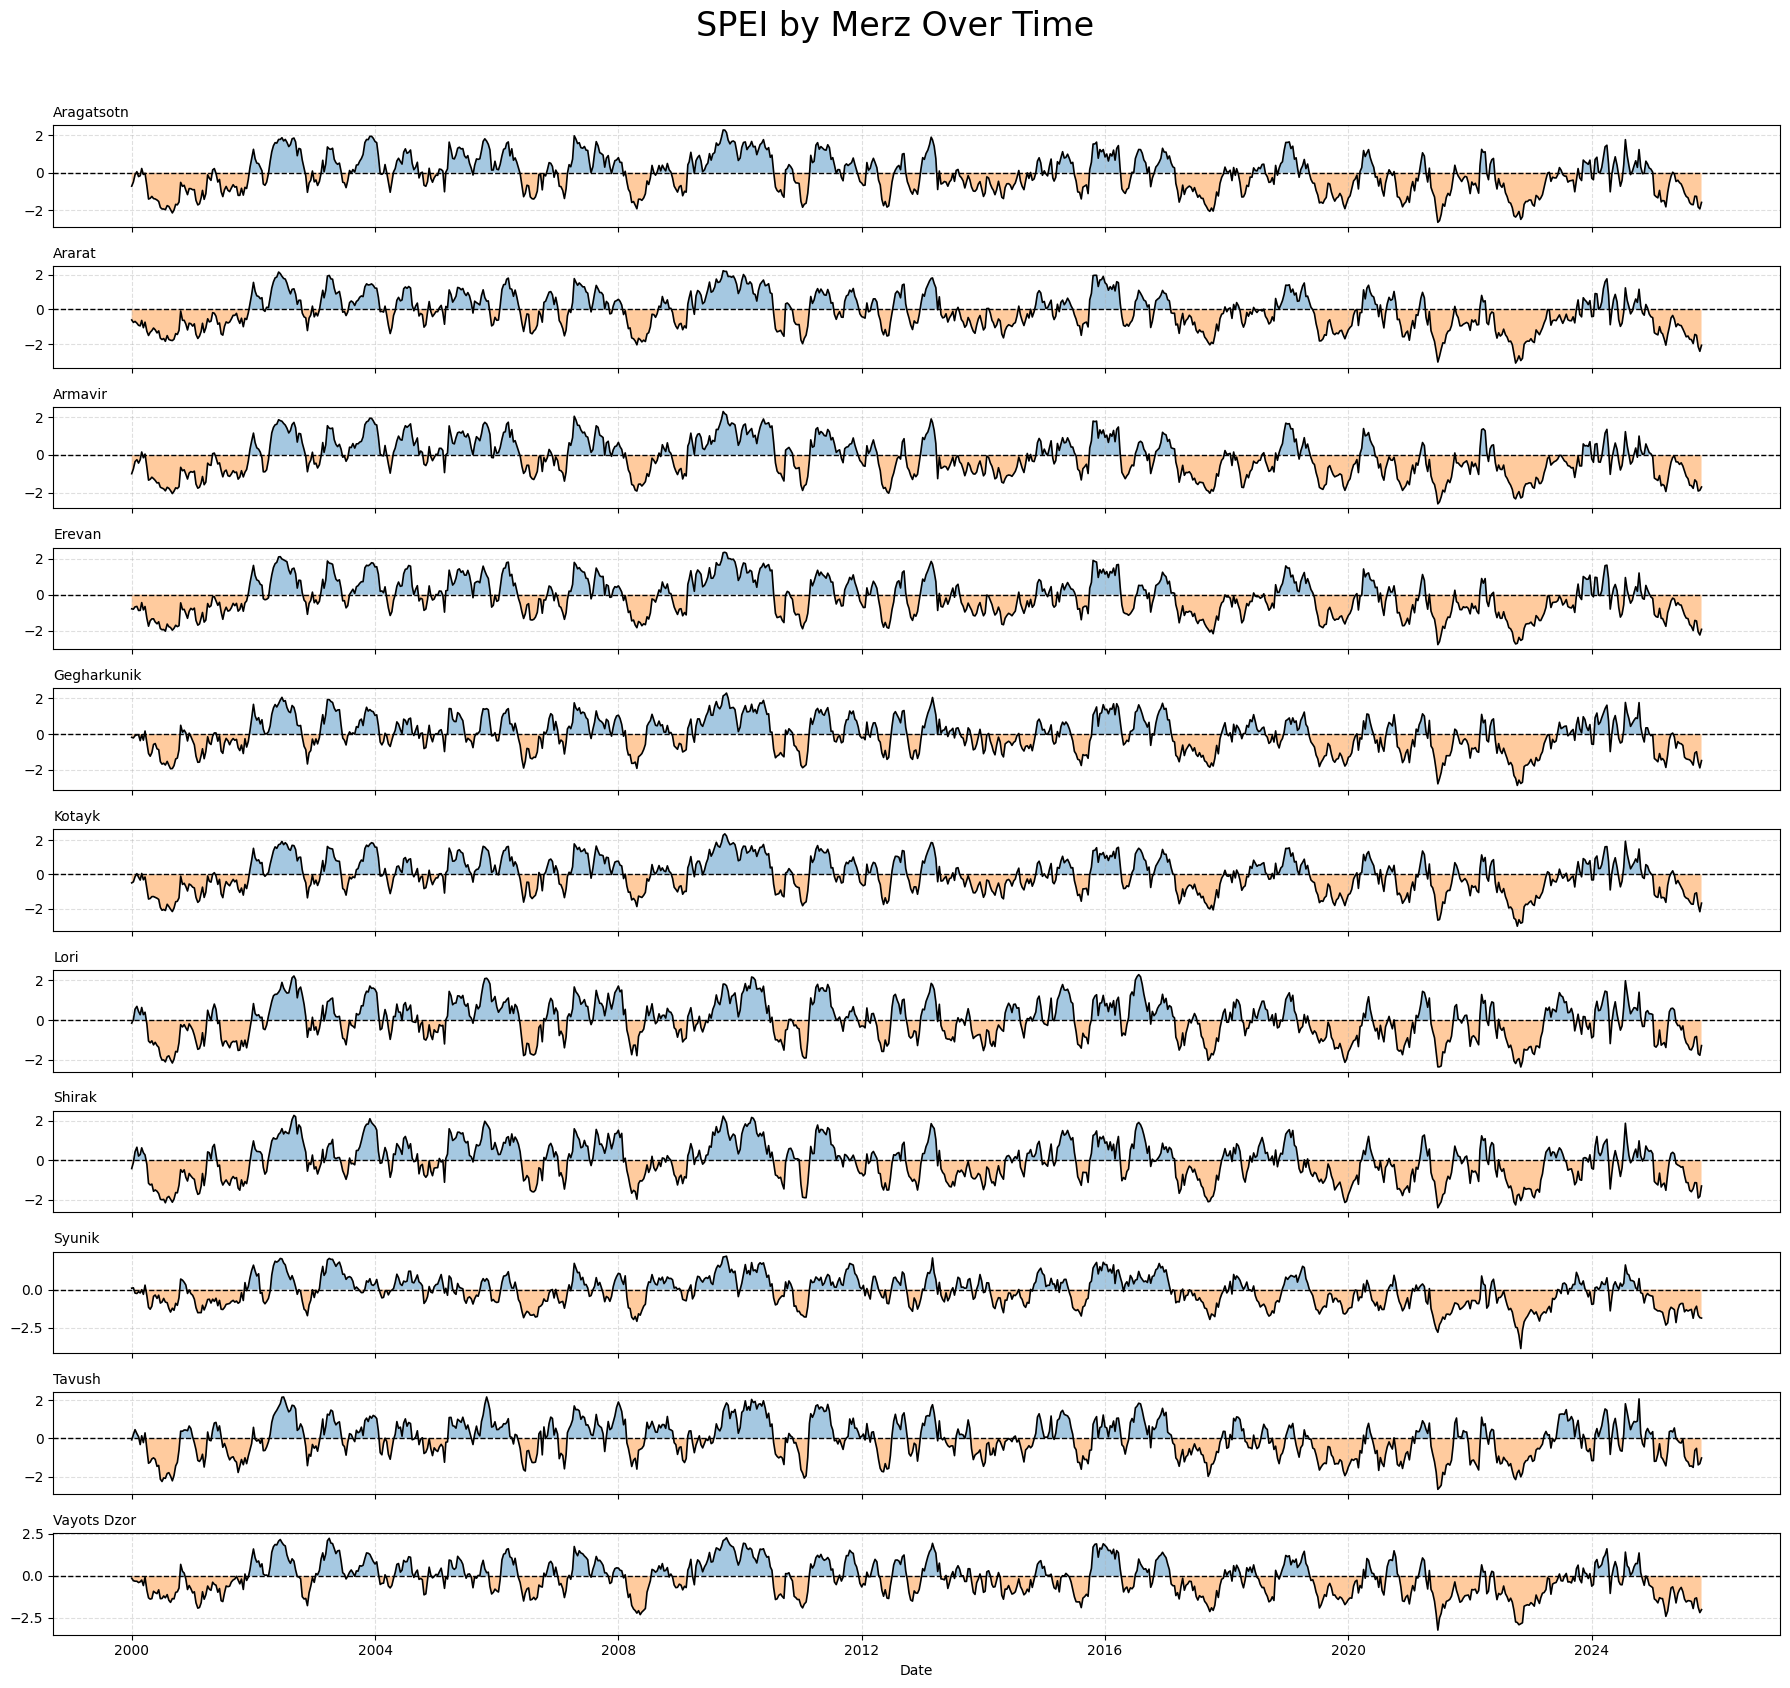

In [3]:
df_ts = df_worker.pivot(index='date', columns='district', values='mean_spei')

# Subplot for each district
n_districts = len(df_ts.columns)
fig, axes = plt.subplots(n_districts, 1, figsize=(18, n_districts * 1.5), sharex=True)

# Loop through districts
for ax, district in zip(axes, df_ts.columns):
    y = df_ts[district]
    x = df_ts.index

    # line
    ax.plot(x, y, color='black', linewidth=1.2)

    # zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    # fill above zero = blue
    ax.fill_between(x, y, 0, where=(y >= 0),
                    interpolate=True, alpha=0.4)

    # fill below zero = red
    ax.fill_between(x, y, 0, where=(y < 0),
                    interpolate=True, alpha=0.4)

    ax.set_title(district, fontsize=10, loc='left')
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_ylabel("", fontsize=8)

plt.xlabel("Date")
plt.suptitle("SPEI by Merz Over Time", fontsize=24, y=1.02)
plt.tight_layout()

plt.savefig(parent_dir / 'figures/spei_district_timeseries.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Define Helper Functions
These are used to transform the data into the values we use in the analysis
The first returns the highest number of consecutive observations below threshhold
the second returns 1 if the prevuous value is above a certain threshold
The thirds returns 1 if the number of observations melow -1 is more than a certain number

In [ ]:
# Define thresholds 
thresh = -1    # threshold for drought observations to count
min_obs = 15 # minimum observations per year
n_consecutive = 10  # minimum consecutive observations per year 

# Function: max consecutive droughts
def max_consecutive_below(series, threshold=thresh):
    """
    Returns the maximum number of consecutive observations where series <= threshold.
    So if in a year there are 12 consecutive observations below threshold, it returns 12.
    If there are 3 separate droughts of lengths 5, 8, and 10, it returns 10.
    """
    is_drought = series <= threshold
    # Convert boolean to int and find max consecutive ones
    groups = (~is_drought).cumsum()
    consecutive_counts = is_drought.groupby(groups).sum()
    return int(consecutive_counts.max()) if not consecutive_counts.empty else 0

# Function: check consecutive droughts
def check_consecutive_drought(series, threshold=thresh, n_consecutive=n_consecutive):
    """
    Returns 1 if there are at least `n_consecutive` observations below threshold, else 0.
    """
    return int(max_consecutive_below(series, threshold) >= n_consecutive) # call the previous function here

# Function: check total droughts per year
def check_total_droughts(series, threshold=thresh, n_required=min_obs):
    """
    Returns 1 if there are at least `n_required` observations <= threshold in the series, else 0.
    """
    return int((series <= threshold).sum() >= n_required)


# Prepare Full Data

In [5]:
df_worker = pd.read_csv(parent_dir / 'drought_data_output/spei3_hf_raw.csv')
df_worker['date'] = pd.to_datetime(df_worker['date'])
df_worker['year'] = df_worker['date'].dt.year

# Step 1: Mark drought months (1 if below threshold)
df_worker['drought_flag'] = (df_worker['mean_spei'] <= thresh).astype(int)

# Step 2: Group by year and apply checks -> by year
# These are the 4 metrics we want to calculate per year and per district
yearly = df_worker.groupby(['district', 'year'])['mean_spei'].agg([
    lambda x: check_consecutive_drought(x),  # 1 if >= n_consecutive
    lambda x: check_total_droughts(x), # 1 if >= min_obs
    lambda x: x.le(thresh).mean(),  # fraction of months that are drought
    lambda x: np.mean(x)  # mean spei
])
print(yearly.head())
yearly.columns = ['consec_drought', 'total_droughts', 'share', 'avg_spei3']
yearly = yearly.reset_index()
yearly


# Rename so it is consistent for merging later
yearly['district'] = yearly['district'].replace({
    'Erevan': 'Yerevan',
    'Vayots Dzor': 'Vayots dzor',
    'Lori': 'Lor',
})

# save to csv
yearly.to_csv(parent_dir / 'drought_data_output/spei3_yearly_master.csv', index=False)


                 <lambda_0>  <lambda_1>  <lambda_2>  <lambda_3>
district   year                                                
Aragatsotn 2000           1           1    0.555556   -1.117279
           2001           0           0    0.333333   -0.754276
           2002           0           0    0.027778    0.808012
           2003           0           0    0.000000    0.523261
           2004           0           0    0.027778    0.263180


# Plot the Dummys


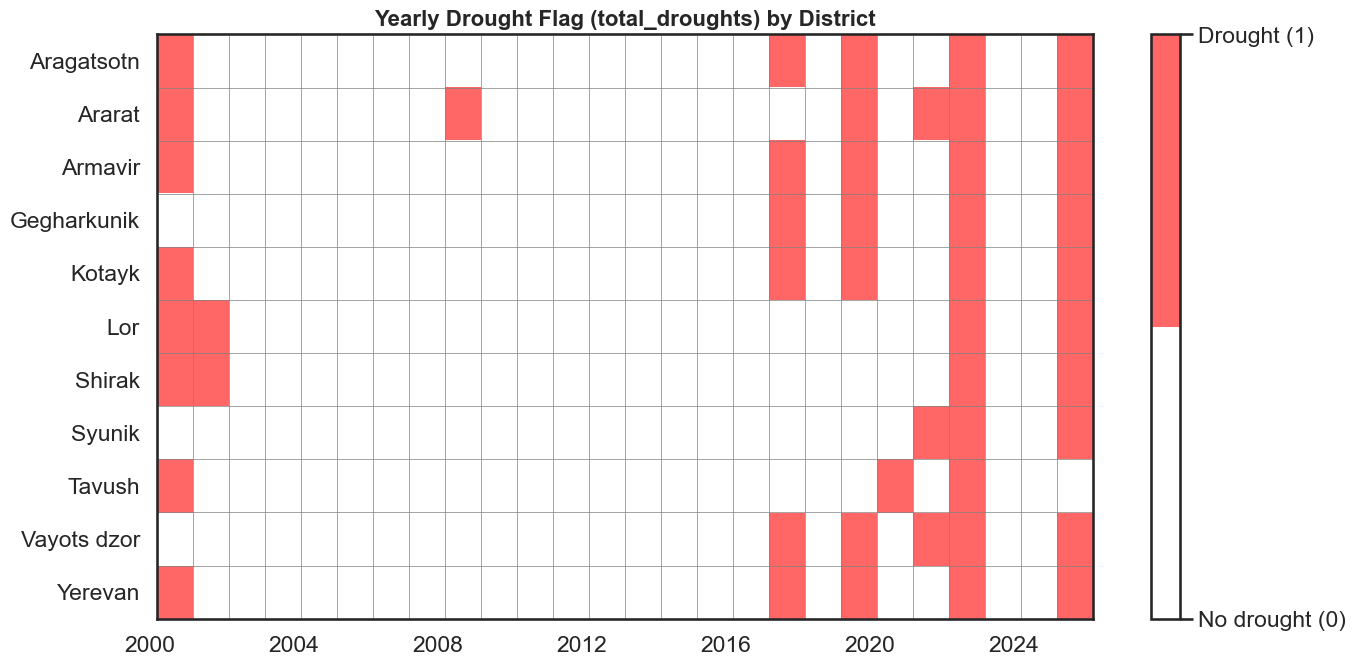

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Setup ---
value = 'total_droughts'  # or 'consec_drought'

# Pivot to matrix (rows = district, cols = year)
pivot = yearly.pivot(index='district', columns='year', values=value).fillna(0).astype(int)

# Extract labels and data
years = pivot.columns.tolist()
districts = pivot.index.tolist()
data = pivot.values

# Seaborn white style without grid
sns.set_theme(style="white", context="talk")

# --- Create heatmap ---
fig, ax = plt.subplots(figsize=(14, 7))

# Use discrete colormap: 0 -> white, 1 -> light red
cmap_flag = ListedColormap(['#ffffff', '#ff6666'])
im = ax.imshow(data, aspect='auto', cmap=cmap_flag, vmin=0, vmax=1)

# set initial ticks and labels
ax.set_xticks(range(len(years)))          
ax.set_yticks(range(len(districts)))

# Show only every 4th year to clean up / district show all
step = 4
ax.set_xticks(range(0, len(years), step))
ax.set_xticklabels([years[i] for i in range(0, len(years), step)], rotation=0, ha='right')
ax.set_yticks(range(len(districts)))
ax.set_yticklabels(districts)

# Grid lines to separate cells needs to be a 0.5 difference as cells are centered at integers
ax.set_xticks([x-0.5 for x in range(1, len(years))], minor=True)
ax.set_yticks([y-0.5 for y in range(1, len(districts))], minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Title, automatic adjustment
ax.set_title(f'Yearly Drought Flag ({value}) by District', fontsize=16, fontweight='bold')

# Colorbar / lege nd
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['No drought (0)', 'Drought (1)'])

plt.tight_layout()
plt.show()


plt.savefig(parent_dir / f'figures/spei3_dummy_{value}.png', dpi=300, bbox_inches='tight')

plt.show()

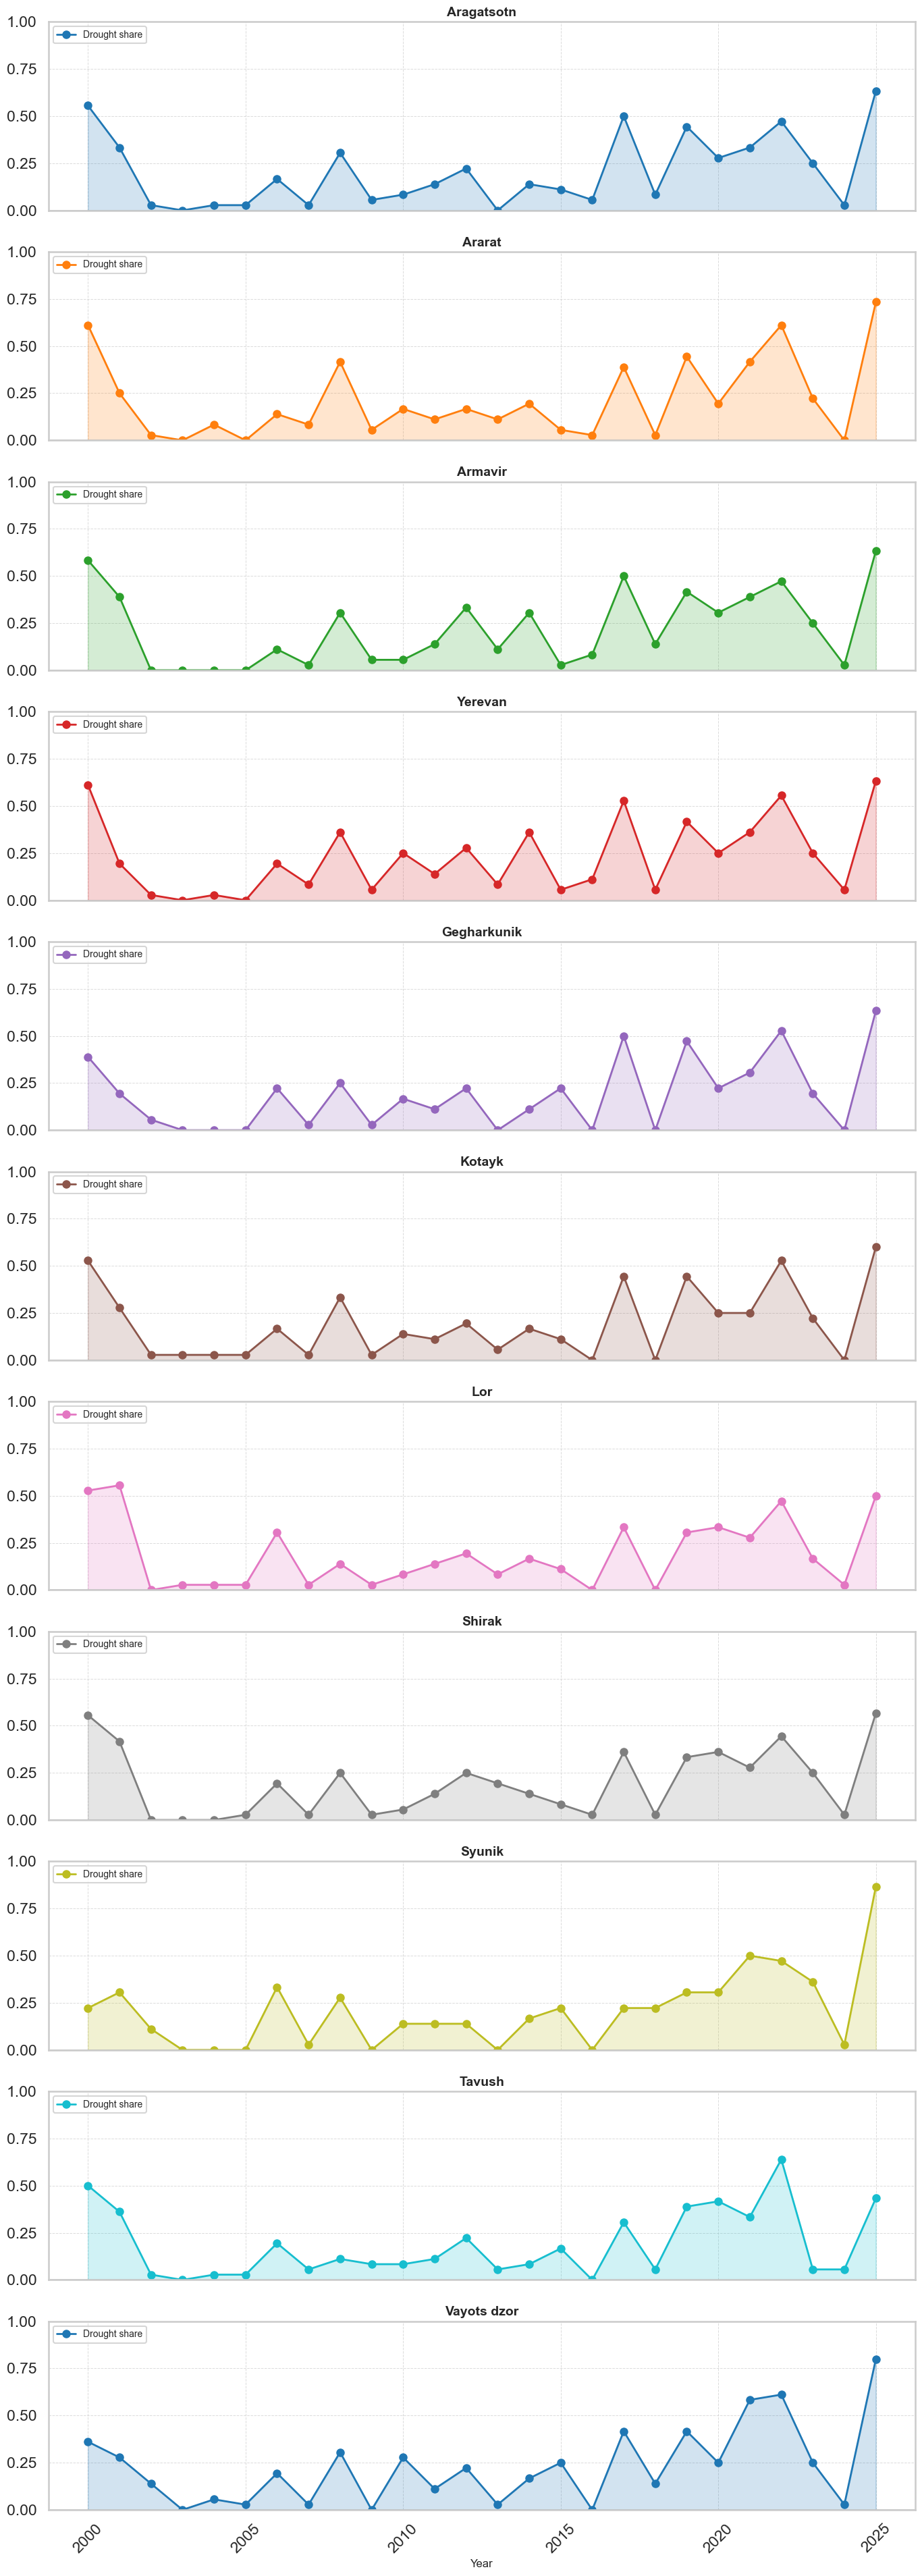

In [ ]:
# Set seaborn style for nicer aesthetics
sns.set_theme(style="whitegrid", context="talk", palette="tab10")

# --- Plot share of droughts for each district ---
districts = yearly['district'].unique()
n_districts = len(districts)

fig, axes = plt.subplots(n_districts, 1, figsize=(14, 3.5*n_districts), sharex=True)

if n_districts == 1:
    axes = [axes]  # ensure axes is iterable

# Optional: assign colors to districts
colors = sns.color_palette("tab10", n_districts)

for ax, district, color in zip(axes, districts, colors):
    data = yearly[yearly['district'] == district]
    
    # Smooth line with markers
    ax.plot(data['year'], data['share'], marker='o', markersize=8,
            linewidth=2, color=color, label='Drought share')
    
    # Fill under the curve for visual emphasis
    ax.fill_between(data['year'], 0, data['share'], color=color, alpha=0.2)
    
    ax.set_title(f'{district}', fontsize=14, fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.axhline(y=0, color='black', linewidth=1)
    ax.legend(loc='upper left', fontsize=10)

axes[-1].set_xlabel('Year', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(parent_dir / 'figures/spei3_drought_share_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()
